# Hierarchical Group Robustness
In this question we focus on the problem of group shift in heirarchical data.
We focus on a modified version of the [iNat2021](https://github.com/visipedia/inat_comp/tree/master/2021) as our target dataset.

## Definitions
**Hierarchical Dataset:** When your data is organized in a hierarchical structure (a tree), each data point has multiple labels corresponding to its predecessors in the hierarchy. For example, a whale is labeled as both a mammal and an animal, while a tulip is labeled as both a plant and a monocot. This means you can assign a label to an entity at every level of categorization in the hierarchy tree.

**A Group** refers to all the data classified under a particular category. For example, all animals fall under the Animalia group, all mammals under the Mammalia group, and all dogs and wolves under the Dog (Canis) group. A group categorized at the $n$'th layer of hierarchy is called a **level-$n$ group**.

The classification under the category of predecessor in $n$'th layer a **level-$n$ classification** (where 0'th layer represents all entities and the root of tree).

Take a look at below image for more clarification.


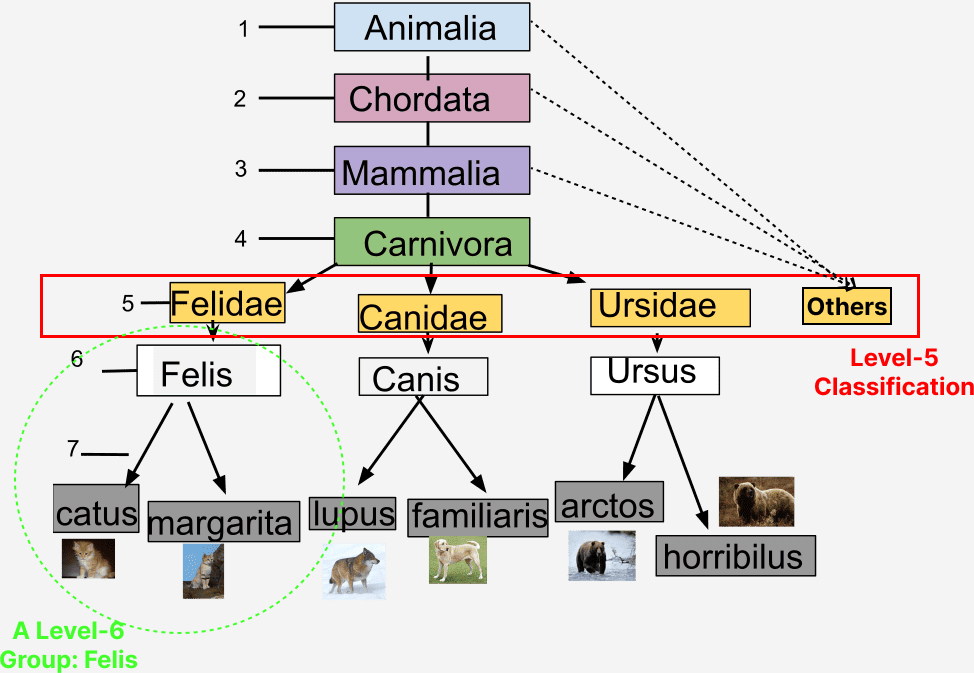

## The Problem
We have a hierarchical dataset (modified-iNat) that is unbalanced across its level-7 groups (the species groups in the iNat dataset). Your task is to train the best level-2 classifier and aim to achieve the best accuracy across all the species indifferently. You may only use Resnet50 as your feature extractor architecture (The exact information about the architecture and the submission method is described thoroughly in the Model Architecture and Submission Format subsections). You can only train and submit the model weights (not the architecture). The exact evaluation method is described below.

### Evaluation Metric
The test set used to evaluate your method is balanced across 10,000 species, which correspond to level-7 groups. Your objective is to maximize the classification accuracy at level-2 for the test set, across all level-X groups. It’s important to note that the classification level (level-2) is different from the group level (level-X) on which the accuracies are calculated.
To measure performance, we first identify the K groups with the lowest accuracies at level-X, then average these accuracies to produce the final metric. Therefore, achieving a high overall average accuracy is not the main focus.
For this problem we set X=7 and K is secret value between 10% and 50% of number of groups.

A simple ERM classifier, without any regard for problem characteristics, is provided in the notebook as a baseline.

**Note:** The class order is determined by concatenating the label of each node from the root to the node, and then sorting these concatenated labels alphabetically.

### Setting up code

In [ ]:
!pip install gdown
!pip install tqdm
!pip install huggingface_hub

In [ ]:
import os

from typing import Iterator
from tqdm import tqdm

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from PIL import Image
import numpy as np
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting up dataset

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='RayanAi/inat_train_modified', filename="inat_train_modified.tar.gz", repo_type="dataset", local_dir=".")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


inat_train_modified.tar.gz:   0%|          | 0.00/11.4G [00:00<?, ?B/s]

'inat_train_modified.tar.gz'

In [ ]:
!tar xfz inat_train_modified.tar.gz -C .

In [ ]:
class Node:
    def __init__(self, name):
        self.name = name
        self._count = 0
        self.children = {}
        self._entities = []

    def add_to_node(self, path, entity, level=0):
        if level >= len(path):
            self._entities.append(entity)
            return
        part = path[level]
        if part not in self.children:
            self.children[part] = Node(path[:level+1])
        self.children[part].add_to_node(path, entity, level=level+1)
        self._count += 1

    @property
    def is_leaf(self):
        return len(self._entities) > 0

    @property
    def count(self):
        if self.is_leaf:
            return len(self._entities)
        else:
            return self._count

    @property
    def entities(self):
        if self.is_leaf:
            return list((entity, self.name) for entity in self._entities)
        else:
            child_entities = []
            for child in self.children.values():
                child_entities.extend(child.entities)
        return child_entities

    def level_iterator(self, level=None):
        """
        iterates a certain depth in a tree and returns the nodes
        """
        if level == 0:
            yield self
        elif level == None and self.is_leaf:
            yield self
        elif self.is_leaf and level != 0:
            raise Exception("Incorrect level is specified in tree.")
        else:
            if level is not None:
                level -= 1
            for child in self.children.values():
                for v in child.level_iterator(level):
                    yield v


    def print_node(self, level=0, max_level=None):
        leaves = 1
        print(' ' * (level * 4) + f"{self.name[-1]} ({self.count})")
        for node in self.children.values():
            if max_level is None or level < max_level:
                leaves += node.print_node(level + 1, max_level=max_level)
        return leaves

In [ ]:
class HiererchicalDataset(Dataset):
    def __init__(self, dataset_path, level=None):
        self.tree = Node("Dataset") # keeps the group information of self.data in a tree (per index).
        self.level = level
        if level is None:
            self.level = 7  # Hardcoded
        self.classes = set()
        data = []
        index = 0
        for group_name in sorted(os.listdir(dataset_path)):
            if not os.path.isdir(os.path.join(dataset_path, group_name)):
                continue
            for image_name in sorted(os.listdir(os.path.join(dataset_path, group_name))):
                group = tuple(group_name.split("_")[1:])
                image_path = os.path.join(dataset_path, group_name, image_name)
                data.append({
                        "image_path": image_path,
                        "group": group,
                    }
                )
                self.tree.add_to_node(group, index)
                index += 1
                self.classes.add(group[:self.level])
        self.data = data
        self.classes = {group: index for (index, group) in enumerate(sorted(list(self.classes)))}
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomCrop(224, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4556, 0.4714, 0.3700), (0.2370, 0.2318, 0.2431))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]["image_path"])
        target = self.classes[self.data[idx]["group"][:self.level]]
        if self.transform:
            image = self.transform(image)

        return image, target

    def get_group_iterator(self, level=None) -> Iterator[Node]:
        for group in self.tree.level_iterator(level):
            yield group

In [ ]:
# Showcase dataset
train_dataset = HiererchicalDataset(dataset_path='train', level=2)
print("Dataset Length:", f"{len(train_dataset)}")
train_dataset.tree.print_node(max_level=2)
print(train_dataset.classes)

Dataset Length: 99970
t (99970)
    Animalia (49112)
        Annelida (13)
        Arthropoda (29675)
        Chordata (18518)
        Cnidaria (124)
        Echinodermata (83)
        Mollusca (699)
    Fungi (1812)
        Ascomycota (396)
        Basidiomycota (1416)
    Plantae (49046)
        Bryophyta (133)
        Chlorophyta (13)
        Marchantiophyta (22)
        Rhodophyta (22)
        Tracheophyta (48856)
{('Animalia', 'Annelida'): 0, ('Animalia', 'Arthropoda'): 1, ('Animalia', 'Chordata'): 2, ('Animalia', 'Cnidaria'): 3, ('Animalia', 'Echinodermata'): 4, ('Animalia', 'Mollusca'): 5, ('Fungi', 'Ascomycota'): 6, ('Fungi', 'Basidiomycota'): 7, ('Plantae', 'Bryophyta'): 8, ('Plantae', 'Chlorophyta'): 9, ('Plantae', 'Marchantiophyta'): 10, ('Plantae', 'Rhodophyta'): 11, ('Plantae', 'Tracheophyta'): 12}


# Training
You are **required** to use a resnet50-backbone, with only changes to the linear head, as your achitecture. The question training time is balanced around training only the classification head, but you are allowed to train the feature extractor as well.

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='RayanAi/resnet50-pretrained-inat', filename="resnet50.pth", repo_type="model", local_dir=".")

resnet50.pth:   0%|          | 0.00/94.5M [00:00<?, ?B/s]

'resnet50.pth'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# class CombinedHead(nn.Module):
#     def __init__(self, in_features, num_classes, num_heads=3):
#         super(CombinedHead, self).__init__()
#         self.heads = nn.ModuleList()
#         for _ in range(num_heads):
#             self.heads.append(
#                 nn.Sequential(
#                     nn.Linear(in_features, 512),
#                     nn.ReLU(),
#                     nn.Dropout(0.5),
#                     nn.Linear(512, num_classes)
#                 )
#             )

#     def forward(self, x):
#         outputs = [head(x) for head in self.heads]
#         avg_output = torch.stack(outputs).mean(0)
#         return avg_output

# # Use combined head on ResNet-50
# model = models.resnet50(pretrained=True)
# model.fc = CombinedHead(model.fc.in_features, len(train_dataset.classes.keys()), num_heads=3)

class CombinedHead(nn.Module):
    def __init__(self, in_features, num_classes, num_heads=1):  # Reduced to 1 head
        super(CombinedHead, self).__init__()
        self.heads = nn.ModuleList()
        for _ in range(num_heads):
            self.heads.append(
                nn.Sequential(
                    nn.Linear(in_features, 512),  # Reduced hidden layer size
                    nn.ReLU(),
                    nn.Dropout(0.3),  # Slightly lower dropout rate
                    nn.Linear(512, num_classes)  # Reduced hidden layer size
                )
            )

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        avg_output = torch.stack(outputs).mean(0) if len(outputs) > 1 else outputs[0]  # Handle single head
        return avg_output

# Use combined head on ResNet-50
model = models.resnet50(pretrained=True)
model.fc = CombinedHead(model.fc.in_features, len(train_dataset.classes.keys()), num_heads=1)

# Optionally, if you want to load your own weights but ignore the fc layer, use strict=False
pretrained_dict = torch.load("resnet50.pth")
model_dict = model.state_dict()

# Filter out `fc` layer weights from the pretrained dictionary
pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('fc')}

# Load the weights into the model
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]
<ipython-input-11-5b3c99d2e1e2>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

<All keys matched successfully>

In [ ]:
# model = models.resnet50(pretrained=False)

# model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes.keys()))

# model.load_state_dict(torch.load("resnet50.pth"))


################### OPTIONAL #########################
model.requires_grad_(False)
model.fc.requires_grad_(True)

CombinedHead(
  (heads): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2048, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=512, out_features=13, bias=True)
    )
  )
)

## Baseline: Simple training on the dataset

In [ ]:
!mkdir -p checkpoints

In [ ]:
import time
from torch.utils.data import DataLoader
import gc
import time
from tqdm import tqdm

# Ensure the checkpoint directory exists
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

experiment_name = "simple-training"
print("Experiment {}".format(experiment_name))

# Hyperparameters
# learning_rate = 0.01
# num_epochs = 20
# batch_size = 256  # Reduced batch size to avoid OOM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


experiment_name = "simple-training"
print("Experiment {}".format(experiment_name))

# Hyperparameters
# learning_rate = 0.01
learning_rate = 0.01
num_epochs = 20
batch_size = 512
checkpoint_dir = "./checkpoints"


# DataLoader (assume `train_dataset` is defined elsewhere)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # Transfer criterion to the right device
# optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

model = model.to(device)  # Transfer model to the right device

# Function to save model checkpoints
def save_checkpoint(state, filename):
    torch.save(state, filename)

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update tqdm progress bar description
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f} | Time: {epoch_time:.2f}s")
    return epoch_loss, epoch_acc

best_acc = 0.0
print(f"Starting training for {num_epochs} epochs.")

# Main training loop
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch, num_epochs)

    # Save the latest model
    latest_checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
    save_checkpoint({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
    }, latest_checkpoint_path)

    print(f"Epoch [{epoch}/{num_epochs}] Summary: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Save the best model based on test accuracy
    if train_acc > best_acc:
        best_acc = train_acc
        best_checkpoint_path = os.path.join(checkpoint_dir, 'best_checkpoint.pth')
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
        }, best_checkpoint_path)
        print(f"New best model saved with accuracy: {best_acc:.4f}")

Experiment simple-training
Experiment simple-training
Starting training for 20 epochs.


Epoch 1 | Training Loss: 0.3725 | Training Accuracy: 0.8892 | Time: 1108.58s
Epoch [1/20] Summary: Train Loss: 0.3725, Train Acc: 0.8892
New best model saved with accuracy: 0.8892


Epoch 2 | Training Loss: 0.2706 | Training Accuracy: 0.9148 | Time: 1098.22s
Epoch [2/20] Summary: Train Loss: 0.2706, Train Acc: 0.9148
New best model saved with accuracy: 0.9148


Epoch 3 | Training Loss: 0.2636 | Training Accuracy: 0.9149 | Time: 1078.60s
Epoch [3/20] Summary: Train Loss: 0.2636, Train Acc: 0.9149
New best model saved with accuracy: 0.9149


Epoch 4 | Training Loss: 0.2583 | Training Accuracy: 0.9168 | Time: 1069.96s
Epoch [4/20] Summary: Train Loss: 0.2583, Train Acc: 0.9168
New best model saved with accuracy: 0.9168


Epoch 5 | Training Loss: 0.2557 | Training Accuracy: 0.9178 | Time: 1071.90s
Epoch [5/20] Summary: Train Loss: 0.2557, Train Acc: 0.9178
New best model saved with accuracy: 0.9178


Epoch 6 | Training Loss: 0.2527 | Training Accuracy: 0.9189 | Time: 1086.57s
Epoch [6/20] Summary: Train Loss: 0.2527, Train Acc: 0.9189
New best model saved with accuracy: 0.9189


Epoch 7 | Training Loss: 0.2518 | Training Accuracy: 0.9181 | Time: 1119.96s
Epoch [7/20] Summary: Train Loss: 0.2518, Train Acc: 0.9181


Epoch 8 | Training Loss: 0.2484 | Training Accuracy: 0.9189 | Time: 1119.02s
Epoch [8/20] Summary: Train Loss: 0.2484, Train Acc: 0.9189


Epoch 9 | Training Loss: 0.2463 | Training Accuracy: 0.9195 | Time: 1120.94s
Epoch [9/20] Summary: Train Loss: 0.2463, Train Acc: 0.9195
New best model saved with accuracy: 0.9195


Epoch 10 | Training Loss: 0.2447 | Training Accuracy: 0.9196 | Time: 1119.01s
Epoch [10/20] Summary: Train Loss: 0.2447, Train Acc: 0.9196
New best model saved with accuracy: 0.9196


Epoch 11/20:  93%|█████████▎| 182/196 [17:30<01:20,  5.75s/it, accuracy=92.01%, loss=0.2318]

In [ ]:
# import time
# from torch.utils.data import DataLoader
# import gc
# import time
# from tqdm import tqdm

# # Ensure the checkpoint directory exists
# checkpoint_dir = "./checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# experiment_name = "simple-training"
# print("Experiment {}".format(experiment_name))

# # Hyperparameters
# # learning_rate = 0.01
# # num_epochs = 20
# # batch_size = 256  # Reduced batch size to avoid OOM
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# experiment_name = "simple-training"
# print("Experiment {}".format(experiment_name))

# # Hyperparameters
# # learning_rate = 0.01
# learning_rate = 0.001
# num_epochs = 20
# batch_size = 512
# checkpoint_dir = "./checkpoints"


# # DataLoader (assume `train_dataset` is defined elsewhere)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss().to(device)  # Transfer criterion to the right device
# # optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# model = model.to(device)  # Transfer model to the right device

# # Function to save model checkpoints
# def save_checkpoint(state, filename):
#     torch.save(state, filename)

# def clear_memory():
#     gc.collect()
#     torch.cuda.empty_cache()

# # Training function
# def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     epoch_start_time = time.time()

#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Track statistics
#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#         # Update tqdm progress bar description
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")

#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     epoch_time = time.time() - epoch_start_time

#     print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f} | Time: {epoch_time:.2f}s")
#     return epoch_loss, epoch_acc

# best_acc = 0.0
# print(f"Starting training for {num_epochs} epochs.")

# # Main training loop
# for epoch in range(1, num_epochs + 1):
#     train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch, num_epochs)

#     # Save the latest model
#     latest_checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
#     save_checkpoint({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'train_loss': train_loss,
#         'train_acc': train_acc,
#     }, latest_checkpoint_path)

#     print(f"Epoch [{epoch}/{num_epochs}] Summary: "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#     # Save the best model based on test accuracy
#     if train_acc > best_acc:
#         best_acc = train_acc
#         best_checkpoint_path = os.path.join(checkpoint_dir, 'best_checkpoint.pth')
#         save_checkpoint({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'train_acc': train_acc,
#         }, best_checkpoint_path)
#         print(f"New best model saved with accuracy: {best_acc:.4f}")

Experiment simple-training
Experiment simple-training
Starting training for 20 epochs.


Epoch 1 | Training Loss: 0.6621 | Training Accuracy: 0.8393 | Time: 1123.32s
Epoch [1/20] Summary: Train Loss: 0.6621, Train Acc: 0.8393
New best model saved with accuracy: 0.8393


Epoch 2 | Training Loss: 0.3796 | Training Accuracy: 0.8986 | Time: 1085.89s
Epoch [2/20] Summary: Train Loss: 0.3796, Train Acc: 0.8986
New best model saved with accuracy: 0.8986


Epoch 3 | Training Loss: 0.3350 | Training Accuracy: 0.9011 | Time: 1084.64s
Epoch [3/20] Summary: Train Loss: 0.3350, Train Acc: 0.9011
New best model saved with accuracy: 0.9011


Epoch 4 | Training Loss: 0.3165 | Training Accuracy: 0.9047 | Time: 1076.38s
Epoch [4/20] Summary: Train Loss: 0.3165, Train Acc: 0.9047
New best model saved with accuracy: 0.9047


Epoch 5 | Training Loss: 0.3061 | Training Accuracy: 0.9063 | Time: 1072.14s
Epoch [5/20] Summary: Train Loss: 0.3061, Train Acc: 0.9063
New best model saved with accuracy: 0.9063


Epoch 6 | Training Loss: 0.2997 | Training Accuracy: 0.9078 | Time: 1075.91s
Epoch [6/20] Summary: Train Loss: 0.2997, Train Acc: 0.9078
New best model saved with accuracy: 0.9078


KeyboardInterrupt: 

In [ ]:
# import torch
# import gc
# import time

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Ensure the checkpoint directory exists
# checkpoint_dir = "./checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# experiment_name = "simple-training"
# print("Experiment {}".format(experiment_name))

# # Hyperparameters
# learning_rate = 0.01
# num_epochs = 20
# batch_size = 512
# checkpoint_dir = "./checkpoints"


# print(f"Dataset Length: {len(train_dataset)}, Batch size: {batch_size}, LR: {learning_rate}")
# # DataLoader (assume `train_dataset` is defined elsewhere)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss().to(device)    # Transfer criterion to the right device
# optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)


# model = model.to(device)

# def save_checkpoint(state, filename):
#     torch.save(state, filename)


# def clear_memory():
#     gc.collect()
#     torch.cuda.empty_cache()

# def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     epoch_start_time = time.time()

#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Clear any lingering memory before forward pass
#         clear_memory()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Statistics
#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#         # Update tqdm progress bar description
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100. * correct / total:.2f}%")

#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     epoch_time = time.time() - epoch_start_time

#     print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f} | Time: {epoch_time:.2f}s")
#     return epoch_loss, epoch_acc

#     # Save the best model based on test accuracy
#     if train_acc > best_acc:
#         best_acc = train_acc
#         best_checkpoint_path = os.path.join(checkpoint_dir, 'best_checkpoint.pth')
#         save_checkpoint({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'train_acc': train_acc,
#         }, best_checkpoint_path)
#         print(f"New best model saved with accuracy: {best_acc:.4f}")

Experiment simple-training
Dataset Length: 99970, Batch size: 512, LR: 0.01


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Submission

In [ ]:
# Submit last layer
import zipfile
torch.save(model.state_dict(), 'resnet.pth')
with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('resnet.pth')
# Upload Procedure

In [ ]:
  !cp submission.zip /content/drive/MyDrive/Colab\ Notebooks/